In [1]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint, uniform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score , r2_score
from sklearn.neural_network import MLPClassifier
import csv
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
test=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
movies=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")

# EDA

In [3]:
categorical_features = {"movies":list(movies.select_dtypes(include=['object', 'category']).columns), "train":list(train.select_dtypes(include=['object', 'category']).columns),"test":list(test.select_dtypes(include=['object', 'category']).columns)}
numerical_features = {"movies":list(movies.select_dtypes(include=['int', 'float', 'complex']).columns),"train":list(train.select_dtypes(include=['int', 'float', 'complex']).columns),"test":list(test.select_dtypes(include=['int', 'float', 'complex']).columns)}

print("Categorical Features:")
[print(i) for i in categorical_features.items()]
print("")
print("Numerical Features:")
[print(i) for i in numerical_features.items()]

Categorical Features:
('movies', ['movieid', 'title', 'rating', 'ratingContents', 'releaseDateTheaters', 'releaseDateStreaming', 'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor', 'soundType'])
('train', ['movieid', 'reviewerName', 'reviewText', 'sentiment'])
('test', ['movieid', 'reviewerName', 'reviewText'])

Numerical Features:
('movies', ['audienceScore', 'runtimeMinutes'])
('train', [])
('test', [])


[None, None, None]

In [4]:
display(train.describe())
display(test.describe())
display(movies.describe())

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


,movieid,reviewerName,isTopCritic,reviewText
count,55315,55315,55315,52805
unique,16786,4495,2,52686
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review
freq,230,428,38428,12


,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


In [5]:
display(train.head())
display(test.head())
display(movies.head())

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


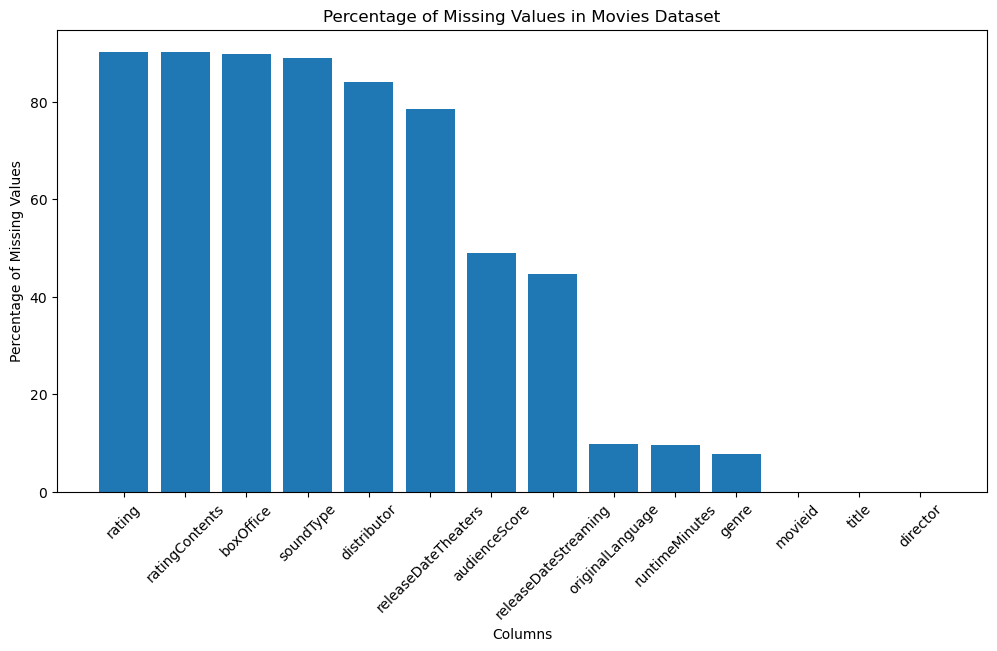

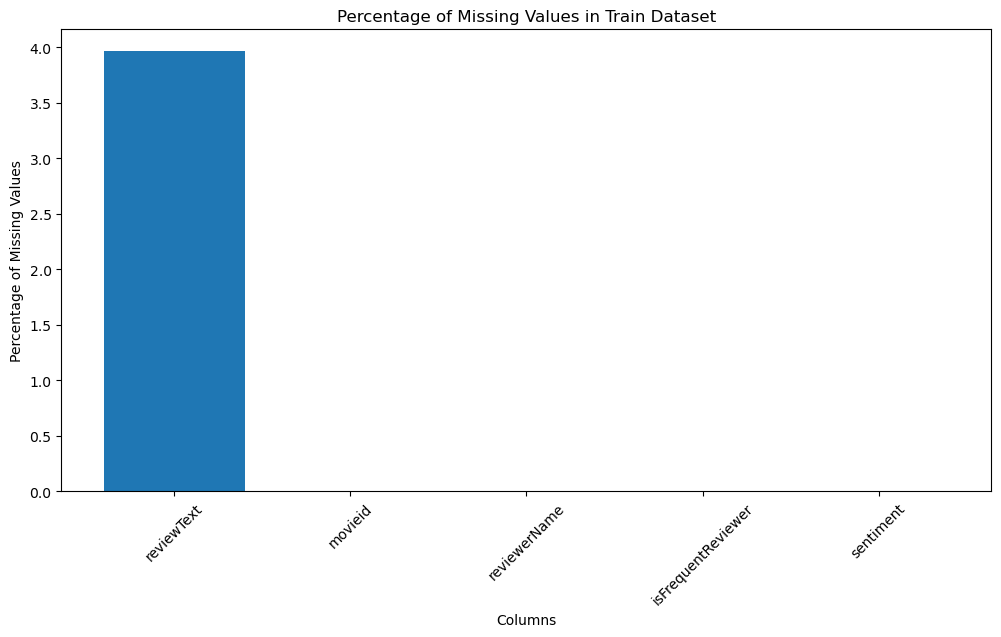

In [6]:
def plot_missing_values(data, title):
    missing_percent = (data.isnull().sum() / len(data)) * 100
    missing_percent = missing_percent.sort_values(ascending=False)

    # Plot the missing values
    plt.figure(figsize=(12, 6))
    plt.bar(missing_percent.index, missing_percent.values)
    plt.xlabel('Columns')
    plt.ylabel('Percentage of Missing Values')
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

plot_missing_values(movies, 'Percentage of Missing Values in Movies Dataset')

plot_missing_values(train, 'Percentage of Missing Values in Train Dataset')

This plot gives us a general idea of the percentage of missing  values in both the  train and movies dataset.
Based on this , columns like rating , ratingContents , boxOffice , soundType , distributor and releaseDateTheaters were excluded first.
Then features like releaseDateStreaming( similar to releaseDateTheaters) and original language was also excluded.

In [7]:
def check_values_not_in_train(test, train, columns):
    not_in_train = {}
    for column in columns:
        unique_values_test = set(test[column].unique())
        unique_values_train = set(train[column].unique())
        difference = unique_values_test - unique_values_train
        not_in_train[column] = len(difference)
    return not_in_train
columns_to_check = ['movieid', 'reviewerName']
not_in_train = check_values_not_in_train(test, train, columns_to_check)
print("Unseen value count->",not_in_train)

Unseen value count-> {'movieid': 104, 'reviewerName': 138}


It was also found during training of the baseline model that there are certain movieids and reviewerNames that were not present in the train but appeared in the test, so I researched about this on the internet and found that featureHasher could help in this scenario. But featureHasher produced inconsistent results in my previous submissions. Therefore I though it would be best to remove them and try with the other features first.

# choosing features

In [8]:
movies = movies.drop_duplicates(subset='movieid', keep='first')
train_df_merged = train.merge(movies[['movieid','genre','director','runtimeMinutes','audienceScore','ratingContents']], on='movieid', how='left')
test_df_merged = test.merge(movies[['movieid', 'genre','director','runtimeMinutes','audienceScore','ratingContents']], on='movieid', how='left')

In [9]:
X_train = train_df_merged[['reviewText','genre','director','runtimeMinutes','audienceScore','ratingContents']]
X_test = test_df_merged[['reviewText','genre','director','runtimeMinutes','audienceScore','ratingContents']]
y_train= train_df_merged['sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

In [10]:
print(X_train.columns)
print(X_test.columns)

Index(['reviewText', 'genre', 'director', 'runtimeMinutes', 'audienceScore',
       'ratingContents'],
      dtype='object')
Index(['reviewText', 'genre', 'director', 'runtimeMinutes', 'audienceScore',
       'ratingContents'],
      dtype='object')


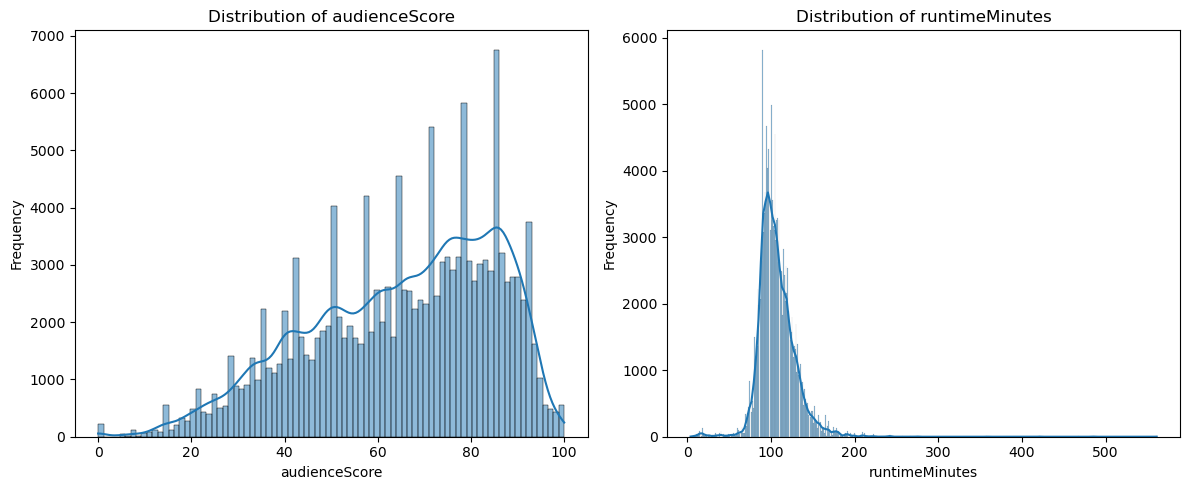

In [11]:
def num_plot():
    cols = ['audienceScore', 'runtimeMinutes']
    plt.figure(figsize=(12, 5))
    for i, col in enumerate(cols, 1):
        plt.subplot(1, 2, i)
        sns.histplot(data=X_train, x=col, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
num_plot()

In [12]:
X_train['reviewText']=X_train['reviewText'].fillna('None')
X_test['reviewText']=X_test['reviewText'].fillna('None')

/tmp/ipykernel_20/3667120262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['reviewText']=X_train['reviewText'].fillna('None')
/tmp/ipykernel_20/3667120262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['reviewText']=X_test['reviewText'].fillna('None')


# Custom listify function to convert each row of genre to a list

In [13]:
def listify_genres(x):
    if isinstance(x[0], str):
        return [x[0]]
    return list(x[0])

# Custom Class for 'genres' 

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
class MultiLabelBinarizerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, classes=None, sparse_output=False):
        self.classes = classes
        self.sparse_output = sparse_output
        self.encoder = MultiLabelBinarizer(classes=self.classes, sparse_output=self.sparse_output)
        
    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self
    
    def transform(self, X, y=None):
        # Handling unknown genre combinations
        for idx, item in enumerate(X):
            X[idx] = [genre if genre in self.encoder.classes_ else 'unknown' for genre in item]
        return self.encoder.transform(X)

# Custom listify function and class to handle 'ratingsContents' of the form '["","",""]'

In [15]:
def convert_to_list(x):
    if isinstance(x, str) and x.startswith("[") and x.endswith("]"):
        items = x[1:-1].split(',')
        return [item.strip().strip('"').strip("'") for item in items]
    return ["No content"]
class RatingContentsBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, classes=None, sparse_output=False):
        self.classes = classes
        self.sparse_output = sparse_output
        self.encoder = MultiLabelBinarizer(classes=self.classes, sparse_output=self.sparse_output)
        
    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self
    
    def transform(self, X, y=None):
#         for idx, item in enumerate(X):
#             X[idx] = [rating_content if rating_content in self.encoder.classes_ else 'unknown' for rating_content in item]
        return self.encoder.transform(X)

The value of the below k_features was found by doing multiple iterations over different values startin from 1000 upto 8000 and it was found that 7500 gave the best score on validation set without exceeding the computational limit

In [16]:
k_features = 7500

# Pipeline

In [17]:
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])
director_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
genre_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('listify', FunctionTransformer(lambda x: [listify_genres(item) for item in x], validate=False)),
    ('encode', MultiLabelBinarizerWrapper())
])
rating_contents_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encode', RatingContentsBinarizer())
])

preprocessor_updated = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 1)), 'reviewText'),
        ('aud_num', num_pipeline, ['audienceScore']),
        ('min_num', num_pipeline, ['runtimeMinutes']), 
        ('genre', genre_pipeline, ['genre']),
        ('ratingContents',rating_contents_pipeline,['ratingContents']),
        ('director', director_pipeline, ['director'])
    ])

GradBoost = Pipeline([
    ('preprocessor', preprocessor_updated),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor_updated),
    ('feature_selection', SelectKBest(f_classif, k=k_features)),
    ('classifier', LogisticRegression(max_iter=1000,solver='saga',random_state=42))
])
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor_updated),
    ('feature_selection', SelectKBest(f_classif, k=k_features)),
    ('classifier', SGDClassifier(loss='hinge',penalty='l2',alpha=0.0001,max_iter=1000,tol=1e-3,random_state=42))
])
SVC_pipeline = Pipeline([
    ('preprocessor', preprocessor_updated),
    ('feature_selection', SelectKBest(f_classif, k=k_features)),
    ('classifier', SVC())
])
MKPClass = Pipeline([
    ('preprocessor', preprocessor_updated),
    ('classifier', MLPClassifier(random_state=42))
])

# Param Grid for Parameter Tuning

In [18]:
param_grid_gb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5]
}
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['lbfgs', 'liblinear', 'saga'],
    'classifier__max_iter': [500, 1000,10000]
}
param_grid_sgd = {
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__penalty': ['l1', 'l2']
}
param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}
param_grid_mlp = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__alpha': [0.0001, 0.001]
}

In [19]:
random_search = RandomizedSearchCV(
    estimator=logreg_pipeline,
    param_distributions=param_grid_lr,
    n_iter=10,
    scoring='f1',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

The value of paramters were found through paramter tuning. But it takes a lot of time for it to train, so the parameters were directly applied 

In [20]:
# random_search.fit(X_train, y_train)
# best_estimator = random_search.best_estimator_
# random_search.best_params_

In [21]:
logreg_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=10000,
                                                                  stop_words='english'),
                                                  'reviewText'),
                                                 ('aud_num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['audienceScore']),
                                                 ('min_num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['runtimeMinutes']),
                                                 ('...
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   RatingContentsBinarizer())]),
                                                  ['ratingContents']),
                                                 ('director',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['director'])])),
                ('feature_selection', SelectKBest(k=7500)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='saga'))])

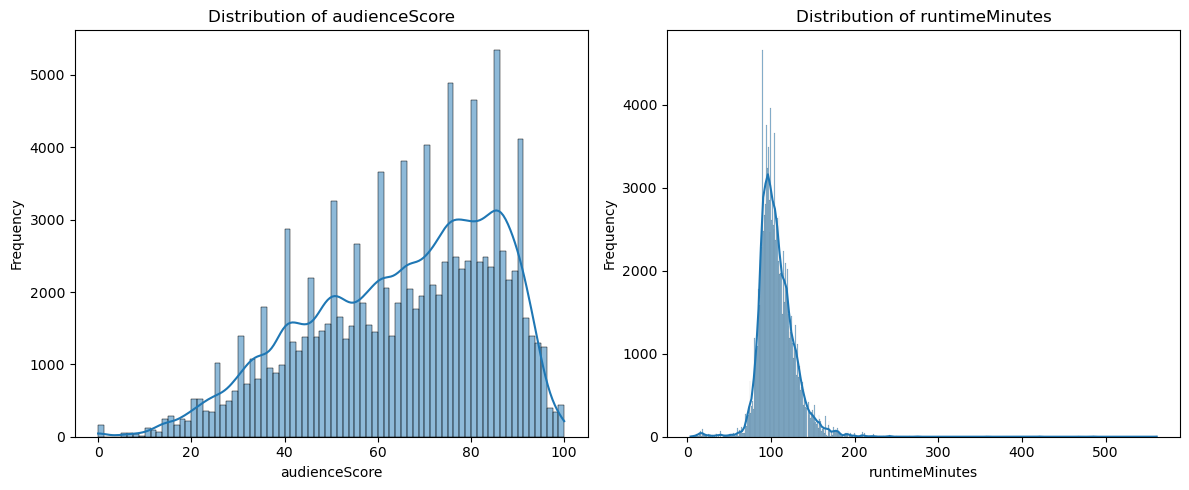

In [22]:
num_plot()

In [23]:
y_pred = logreg_pipeline.predict(X_val)
accuracy = f1_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ["['A Brief Drug Reference', 'Some Rude Humor']", "['A Brief Violent Image', 'Some Thematic Elements']", "['A Crude Reference', 'Some Sexual Material', 'Brief Strong Language']", "['A Sequence of Nudity', 'Some Disturbing Images']", "['Bloody Violence', 'Sexual Content', 'Nudity']", "['Brief Language', 'Some Mild Thematic Elements']", "['Brief Language', 'Violent Images']", "['Brief Nudity', 'Sexual References', 'Pervasive Language']", "['Brief Sexual Material', 'Some Language']", "['Brief Violence/Bloody Images']", "['Comic Violent Images', 'Drug Content']", "['Dialogue', 'Strong Sexual Content', 'Nudity']", "['Drug Content', 'Language']", "['Drug Use', 'Disturbing Images', 'Language', 'Some Nudity', 'Violence']", "['Gore', 'Drug Use', 'Bloody Horror Violence', 'Language', 'Some Sexual Content/Nudity']", "['Language Throughout', 'Drug Use', 'A Brief Nude Image', 'Violence']", "[

Accuracy: 86.57%


[[ 6696  4000]
 [ 2124 19732]]


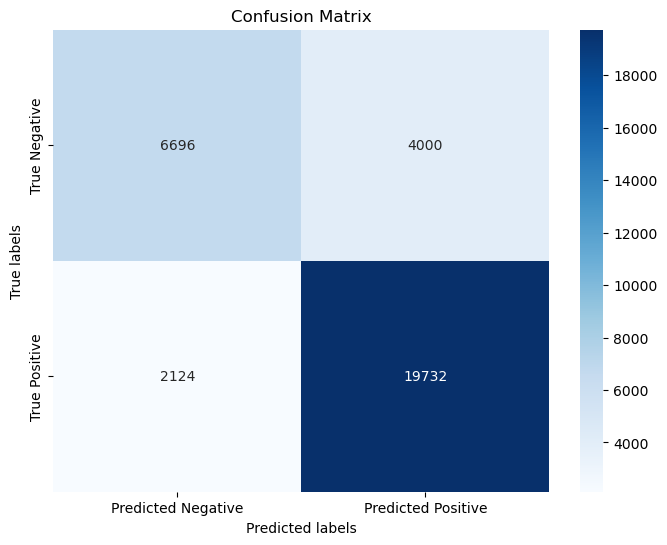

In [24]:
cm = confusion_matrix(y_val, y_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
predictions = logreg_pipeline.predict(X_test)
ids = range(len(predictions))
predictions=['POSITIVE' if x==1 else 'NEGATIVE' for x in predictions]
final_prediction = pd.DataFrame({"id": ids, "sentiment": predictions})
final_prediction.to_csv("submission.csv", index = False)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ["['A Brief Drug Reference', 'Some Rude Humor']", "['A Brief Violent Image', 'Some Thematic Elements']", "['A Crude Reference', 'Some Sexual Material', 'Brief Strong Language']", "['A Sequence of Nudity', 'Some Disturbing Images']", "['Bloody Violence', 'Sexual Content', 'Nudity']", "['Bloody Violence', 'Terror', 'Disturbing Images']", "['Brief Language', 'Some Mild Thematic Elements']", "['Brief Language', 'Violent Images']", "['Brief Nudity', 'Sexual References', 'Pervasive Language']", "['Brief Sexual Material', 'Some Language']", "['Brief Violence/Bloody Images']", "['Comic Violent Images', 'Drug Content']", "['Dialogue', 'Strong Sexual Content', 'Nudity']", "['Drug Content', 'Language']", "['Drug Use', 'Disturbing Images', 'Language', 'Some Nudity', 'Violence']", "['Gore', 'Drug Use', 'Bloody Horror Violence', 'Language', 'Some Sexual Content/Nudity']", "['Language Throughou

# some insights

Various machine learning models were trained using different combinations of features. Given the time constraints, the chosen feature set yielded the best performance. A summary of the models and their results is provided below:

**Baseline Model**: The logistic regression model was selected as the baseline due to its consistent performance and robustness to feature tuning. It outperformed other classifiers in terms of accuracy and interpretability.

**SGD Classifier**: The next best classifier was the Stochastic Gradient Descent (SGD) classifier with the loss function set to 'hinge,' effectively behaving as a Support Vector Machine (SVM). It provided competitive results with relatively low computational cost.

**SVC**: The Support Vector Classifier (SVC) was considered, but due to its high computational time, it was not feasible to implement within the given time constraints. An attempt was made to train an SVC model without a pipeline, but the training process took more than 12 hours and was abruptly terminated.

**Decision Trees**: Decision tree models were explored but yielded poorer results compared to the logistic regression and SGD classifiers.

**Bagging and Boosting**: Ensemble methods such as bagging and boosting were evaluated but did not outperform the logistic regression and SGD classifiers.

**Feature Selection**: Certain features, such as 'movieid' and 'reviewername,' were excluded from the model due to their presence of numerous unseen unique values in the test dataset, which posed challenges for generalization.

In conclusion, the logistic regression model with the selected feature set emerged as the best-performing model for this analysis. Future work may explore more advanced classifiers or feature engineering techniques to further improve model performance.


In [26]:
final_prediction


,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,NEGATIVE
55312,55312,NEGATIVE
55313,55313,POSITIVE


In [27]:
print("No. of negative labels: ",y_train[y_train==0].count())
print("No. of positive labels: ",y_train[y_train==1].count())

No. of negative labels:  43301
No. of positive labels:  86905


# Things I could have done
* **Use Balancing Techniques** - As we can see from the cell above , that the number of positive labels are almost twice the negative labels. Hence, the data is very imbalanced and we could have used balancing techniques for potentially better results 
* **Use of LinearSVC** - From my mentioned insight, we know that LogisticRegression(tuned and untuned) has been performing better than the SVC for our set of features. It could have been worthwhile to try LinearSVC

In [28]:
logreg_pipeline_bal = imbPipeline([
    ('preprocessor', preprocessor_updated),
    ('smote',SMOTE(random_state=42)),
    ('feature_selection', SelectKBest(f_classif, k=k_features)),
    ('classifier', LogisticRegression(max_iter=1000,solver='saga',random_state=42))
])
logreg_pipeline_bal.fit(X_train,y_train)
y_pred = logreg_pipeline_bal.predict(X_val)
accuracy = f1_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
predictions = logreg_pipeline.predict(X_test)
ids = range(len(predictions))
predictions=['POSITIVE' if x==1 else 'NEGATIVE' for x in predictions]
final_prediction = pd.DataFrame({"id": ids, "sentiment": predictions})
final_prediction.to_csv("submission2.csv", index = False)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ["['A Brief Drug Reference', 'Some Rude Humor']", "['A Brief Violent Image', 'Some Thematic Elements']", "['A Crude Reference', 'Some Sexual Material', 'Brief Strong Language']", "['A Sequence of Nudity', 'Some Disturbing Images']", "['Bloody Violence', 'Sexual Content', 'Nudity']", "['Brief Language', 'Some Mild Thematic Elements']", "['Brief Language', 'Violent Images']", "['Brief Nudity', 'Sexual References', 'Pervasive Language']", "['Brief Sexual Material', 'Some Language']", "['Brief Violence/Bloody Images']", "['Comic Violent Images', 'Drug Content']", "['Dialogue', 'Strong Sexual Content', 'Nudity']", "['Drug Content', 'Language']", "['Drug Use', 'Disturbing Images', 'Language', 'Some Nudity', 'Violence']", "['Gore', 'Drug Use', 'Bloody Horror Violence', 'Language', 'Some Sexual Content/Nudity']", "['Language Throughout', 'Drug Use', 'A Brief Nude Image', 'Violence']", "[

Accuracy: 84.31%


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ["['A Brief Drug Reference', 'Some Rude Humor']", "['A Brief Violent Image', 'Some Thematic Elements']", "['A Crude Reference', 'Some Sexual Material', 'Brief Strong Language']", "['A Sequence of Nudity', 'Some Disturbing Images']", "['Bloody Violence', 'Sexual Content', 'Nudity']", "['Bloody Violence', 'Terror', 'Disturbing Images']", "['Brief Language', 'Some Mild Thematic Elements']", "['Brief Language', 'Violent Images']", "['Brief Nudity', 'Sexual References', 'Pervasive Language']", "['Brief Sexual Material', 'Some Language']", "['Brief Violence/Bloody Images']", "['Comic Violent Images', 'Drug Content']", "['Dialogue', 'Strong Sexual Content', 'Nudity']", "['Drug Content', 'Language']", "['Drug Use', 'Disturbing Images', 'Language', 'Some Nudity', 'Violence']", "['Gore', 'Drug Use', 'Bloody Horror Violence', 'Language', 'Some Sexual Content/Nudity']", "['Language Throughou

In [29]:
# SVC_pipeline_bal = imbPipeline([
#     ('preprocessor', preprocessor_updated),
#     ('smote',SMOTE(random_state=42)),
#     ('feature_selection', SelectKBest(f_classif, k=k_features)),
#     ('classifier', SVC())
# ])
# SVC_pipeline_bal.fit(X_train,y_train)
# y_pred = SVC_pipeline_bal.predict(X_val)
# accuracy = f1_score(y_val, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")